Im downloading few utility Python scripts directly from the PyTorch Vision repository, which contain helper functions for training and evaluation of detection models.

In [1]:
!pip install -q torch torchvision torchaudio
!pip install -q albumentations numpy pandas matplotlib opencv-python pycocotools

!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py

print("Libraries installed and utility files downloaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import time
import importlib
import utils
import coco_utils
import engine


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


This cell defines a configuration class `TrainConfig` to hold all important hyperparameters and settings for the training process.  Parameters include data paths, image size, batch size, number of epochs, learning rate, optimizer settings, device selection, train/validation split details, and early stopping patience.

In [3]:
class TrainConfig:
    data_dir = '/kaggle/input/cavity'
    image_dir = os.path.join(data_dir, 'def-images-20250415T155900Z-001/def-images')
    mask_dir = os.path.join(data_dir, 'maks_images-20250415T155946Z-001/maks_images')

    image_size = 256 
    batch_size = 16
    num_epochs = 100
    learning_rate = 0.0001
    weight_decay = 0.0005
    num_classes = 2 
    early_stopping_patience = 15

    test_split_ratio = 0.2
    random_state = 42

    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

train_config = TrainConfig()

print(f"Selected device: {train_config.device}")
print(f"Image directory: {train_config.image_dir}")
print(f"Mask directory: {train_config.mask_dir}")
print(f"Image Size: {train_config.image_size}")
print(f"Batch Size: {train_config.batch_size}")
print(f"Epochs: {train_config.num_epochs}")
print(f"Learning Rate: {train_config.learning_rate}")
print(f"Early Stopping Patience: {train_config.early_stopping_patience}")

Selected device: cuda
Image directory: /kaggle/input/cavity/def-images-20250415T155900Z-001/def-images
Mask directory: /kaggle/input/cavity/maks_images-20250415T155946Z-001/maks_images
Image Size: 256
Batch Size: 16
Epochs: 100
Learning Rate: 0.0001
Early Stopping Patience: 15


This cell prepares the dataset information. It lists image and mask files, checks for mismatches, creates a unique integer ID for each image, and builds a Pandas DataFrame containing paths and IDs.

In [4]:
# get sorted list of image and mask files
image_files = sorted([f for f in os.listdir(train_config.image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(train_config.mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

# check for mismatch between image and mask counts
if len(image_files) != len(mask_files):
    print(f"Warning: Mismatch in number of images ({len(image_files)}) and masks ({len(mask_files)})")

# Map image filenames (without extension) to integer IDs
image_file_to_int_id = {os.path.splitext(f)[0]: i for i, f in enumerate(image_files)}

df_data = []

# Use extension of the first mask file
mask_ext = os.path.splitext(mask_files[0])[-1] if mask_files else '.png'

# Build list of image-mask pairs with full paths
for img_file in image_files:
    base_name = os.path.splitext(img_file)[0]
    mask_file = base_name + mask_ext
    mask_path = os.path.join(train_config.mask_dir, mask_file)

    if os.path.exists(mask_path):
        df_data.append({
            'image_id_str': base_name,
            'img_int_id': image_file_to_int_id[base_name],
            'image_path': os.path.join(train_config.image_dir, img_file),
            'mask_path': mask_path
        })
    else:
        print(f"Mask file '{mask_file}' not found for image '{img_file}', skipping image.")

# Create DataFrame
df = pd.DataFrame(df_data)

# Split into training and validation sets
train_df, valid_df = train_test_split(
    df,
    test_size=train_config.test_split_ratio,
    random_state=train_config.random_state,
    stratify=None
)

# Print summary
print(f"Total samples processed: {len(df)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")


Total samples processed: 300
Training samples: 240
Validation samples: 60


This cell defines the various augmentations I used for the dataset

In [5]:

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

def get_train_transform(image_size):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.15, rotate_limit=25, p=0.7,
                           border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=15, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),

        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_valid_transform(image_size):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()

    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

This is the main dataset class which inherits from the torch,utils.data.dataset. Its __getitem__ method is responsible for loading an image and its corresponding mask, finding distinct cavities using contour detection, extracting bounding boxes and individual instance masks, applying augmentations, and returning the processed image and target dictionary in the format required by torchvision's Mask R-CNN model. 


In [6]:
import cv2
import numpy as np
import torch
import pandas as pd

class CavityInstanceDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms=None):
        self.df = dataframe.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        mask_path = row['mask_path']
        img_int_id = row['img_int_id']

        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None: raise FileNotFoundError(f"Image not found: {image_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_height, img_width = img.shape[:2]

        # Load mask in grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: raise FileNotFoundError(f"Mask not found: {mask_path}")

        # Find contours of cavity regions (connected components)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        initial_numpy_masks = []
        initial_boxes = []
        initial_labels = []

        for contour in contours:
            if cv2.contourArea(contour) < 10:
                continue  # Ignore small/noisy regions

            x, y, w, h = cv2.boundingRect(contour)
            bbox = [x, y, x + w, y + h]

            # Skip invalid bounding boxes
            if bbox[0] >= bbox[2] or bbox[1] >= bbox[3]:
                continue

            # Clamp bounding box to image bounds
            bbox[0] = max(0, bbox[0])
            bbox[1] = max(0, bbox[1])
            bbox[2] = min(img_width, bbox[2])
            bbox[3] = min(img_height, bbox[3])

            if bbox[0] >= bbox[2] or bbox[1] >= bbox[3]:
                continue

            # Create binary mask for this instance
            instance_mask_np = np.zeros_like(mask, dtype=np.uint8)
            cv2.drawContours(instance_mask_np, [contour], -1, color=1, thickness=cv2.FILLED)

            initial_numpy_masks.append(instance_mask_np)
            initial_boxes.append(bbox)
            initial_labels.append(1)  # Label is always 1 for cavity

        # Prepare data for transformations
        target_for_transform = {
            'image': img,
            'masks': initial_numpy_masks,
            'bboxes': initial_boxes,
            'labels': initial_labels
        }

        # Apply transforms 
        transformed_boxes = initial_boxes
        transformed_masks = initial_numpy_masks
        transformed_labels = initial_labels

        if self.transforms:
            transformed = self.transforms(**target_for_transform)
            img = transformed['image']
            transformed_boxes = transformed['bboxes']
            transformed_masks = transformed['masks']
            transformed_labels = transformed['labels']

        # Validate transformed data
        final_boxes_list = []
        final_masks_list = []
        final_labels_list = []

        for i, bbox in enumerate(transformed_boxes):
            xmin, ymin, xmax, ymax = bbox
            if xmin < xmax and ymin < ymax:
                if i < len(transformed_masks) and i < len(transformed_labels):
                    final_boxes_list.append(list(bbox))
                    final_masks_list.append(transformed_masks[i])
                    final_labels_list.append(transformed_labels[i])

        target = {}
        target["image_id"] = torch.tensor([img_int_id], dtype=torch.int64)
        img_h_final, img_w_final = img.shape[1], img.shape[2]  # For mask shape

        if final_boxes_list:
            target["boxes"] = torch.as_tensor(final_boxes_list, dtype=torch.float32)
            target["labels"] = torch.as_tensor(final_labels_list, dtype=torch.int64)

            if final_masks_list:
                # Ensure all masks are numpy arrays
                masks_np = [m if isinstance(m, np.ndarray) else np.array(m) for m in final_masks_list]
                target["masks"] = torch.as_tensor(np.array(masks_np), dtype=torch.uint8)
            else:
                target["masks"] = torch.zeros((0, img_h_final, img_w_final), dtype=torch.uint8)

            # Check mask shape and correct if needed
            if target["masks"].ndim == 2:
                if target["masks"].shape == (img_h_final, img_w_final):
                    target["masks"] = target["masks"].unsqueeze(0)
                else:
                    print(f"Warning: Mask shape mismatch for img_id {img_int_id}. Got {target['masks'].shape}, expected H={img_h_final}, W={img_w_final}")
                    target["masks"] = torch.zeros((0, img_h_final, img_w_final), dtype=torch.uint8)
            elif target["masks"].ndim != 3 and target["masks"].shape[0] > 0:
                print(f"Warning: Incorrect mask dimensions for img_id {img_int_id}. Shape: {target['masks'].shape}")
                target["masks"] = torch.zeros((0, img_h_final, img_w_final), dtype=torch.uint8)

            # Area and crowd info for COCO-style evaluation
            target["area"] = (target["boxes"][:, 3] - target["boxes"][:, 1]) * \
                             (target["boxes"][:, 2] - target["boxes"][:, 0])
            target["iscrowd"] = torch.zeros((len(final_boxes_list),), dtype=torch.int64)
        else:
            # Handle images with no valid objects
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros(0, dtype=torch.int64)
            target["masks"] = torch.zeros((0, img_h_final, img_w_final), dtype=torch.uint8)
            target["area"] = torch.zeros(0, dtype=torch.float32)
            target["iscrowd"] = torch.zeros(0, dtype=torch.int64)

        # Convert image to torch tensor if it's still a numpy array
        if not isinstance(img, torch.Tensor):
            img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0

        return img, target


In [7]:
train_dataset = CavityInstanceDataset(train_df, transforms=get_train_transform(train_config.image_size))
valid_dataset = CavityInstanceDataset(valid_df, transforms=get_valid_transform(train_config.image_size))


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config.batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn,
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=train_config.batch_size,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn,
    pin_memory=True
)

print(f"DataLoaders created.")
print(f"Train loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(valid_loader)}")
print(f"Train loader num_workers: {train_loader.num_workers}")
print(f"Validation loader num_workers: {valid_loader.num_workers}")

DataLoaders created.
Train loader batches: 15
Validation loader batches: 4
Train loader num_workers: 1
Validation loader num_workers: 1


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_31/3295299668.py:11: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.15, rotate_limit=25, p=0.7,
/tmp/ipykernel_31/3295299668.py:16: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


This cell defines the instance segmentation model. Im use a pre-trained Mask R-CNN model from with a ResNet-50 FPN backbone.

In [8]:
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_mask_rcnn_model(num_classes):
    #  pre-trained Mask R-CNN with ResNet-50 backbone and FPN 
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

    # Replace box predictor head (for classification and bbox regression)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace mask predictor head
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256 
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

model = get_mask_rcnn_model(train_config.num_classes)
model.to(train_config.device)

print(f"Mask R-CNN model (ResNet-50 FPN V2) loaded and moved to {train_config.device}.")


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:00<00:00, 195MB/s] 


Mask R-CNN model (ResNet-50 FPN V2) loaded and moved to cuda.


In [9]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(
    params,
    lr=train_config.learning_rate,
    weight_decay=train_config.weight_decay
)


lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=train_config.num_epochs,
    eta_min=1e-7
)

print(f"Optimizer: AdamW (LR={train_config.learning_rate}, WD={train_config.weight_decay})")
print(f"Scheduler: CosineAnnealingLR (T_max={train_config.num_epochs}, eta_min={1e-7})")

Optimizer: AdamW (LR=0.0001, WD=0.0005)
Scheduler: CosineAnnealingLR (T_max=100, eta_min=1e-07)


I had to overwrite the scripts below to ensure integer image_ids are used when creating the COCO ground truth object

In [10]:
%%writefile /kaggle/working/coco_utils.py

import os
import torch
import torch.utils.data
import torchvision
import numpy as np
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO


def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3: mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks: masks = torch.stack(masks, dim=0)
    else: masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks

class ConvertCocoPolysToMask:
    def __call__(self, image, target):
        w, h = image.size; image_id = target["image_id"]; anno = target["annotations"]
        anno = [obj for obj in anno if obj["iscrowd"] == 0]; boxes = [obj["bbox"] for obj in anno]
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4); boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w); boxes[:, 1::2].clamp_(min=0, max=h)
        classes = [obj["category_id"] for obj in anno]; classes = torch.tensor(classes, dtype=torch.int64)
        segmentations = [obj["segmentation"] for obj in anno]; masks = convert_coco_poly_to_mask(segmentations, h, w)
        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]; keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints: keypoints = keypoints.view(num_keypoints, -1, 3)
        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0]); boxes = boxes[keep]; classes = classes[keep]; masks = masks[keep]
        if keypoints is not None: keypoints = keypoints[keep]
        target_out = {}; target_out["boxes"] = boxes; target_out["labels"] = classes; target_out["masks"] = masks; target_out["image_id"] = image_id
        if keypoints is not None: target_out["keypoints"] = keypoints
        area = torch.tensor([obj["area"] for obj in anno]); iscrowd = torch.tensor([obj["iscrowd"] for obj in anno])
        # Note: Original filtering doesn't update area/iscrowd properly. Consider recalculating if needed.
        target_out["area"] = area[keep] if keep.any() else torch.zeros(0); target_out["iscrowd"] = iscrowd[keep] if keep.any() else torch.zeros(0)
        return image, target_out


def convert_to_coco_api(ds):
    coco_ds = COCO()
    ann_id = 1
    dataset = {"images": [], "categories": [], "annotations": []}
    categories = set()
    print(f"Converting dataset ({len(ds)} images) to COCO format...")
    for img_idx in range(len(ds)):
        try:
            img, targets = ds[img_idx]

            image_id = targets["image_id"].item() if isinstance(targets["image_id"], torch.Tensor) else int(targets["image_id"])

            img_dict = {}
            img_dict["id"] = image_id

            img_dict["height"] = img.shape[-2]
            img_dict["width"] = img.shape[-1]
            dataset["images"].append(img_dict)


            if "boxes" in targets and len(targets["boxes"]) > 0:
                bboxes = targets["boxes"].cpu().clone()
                bboxes[:, 2:] -= bboxes[:, :2]
                bboxes = bboxes.tolist()
                labels = targets["labels"].cpu().tolist()
                areas = targets.get("area", torch.zeros(len(labels))).cpu().tolist()
                iscrowd = targets.get("iscrowd", torch.zeros(len(labels))).cpu().tolist()
                masks = targets.get("masks")
                keypoints = targets.get("keypoints")

                if masks is not None:
                    masks = masks.cpu().permute(0, 2, 1).contiguous().permute(0, 2, 1)
                if keypoints is not None:
                    keypoints = keypoints.cpu().reshape(keypoints.shape[0], -1).tolist()

                num_objs = len(bboxes)
                for i in range(num_objs):
                    ann = {}
                    ann["image_id"] = image_id
                    ann["bbox"] = bboxes[i]
                    ann["category_id"] = labels[i]
                    categories.add(labels[i])
                    ann["area"] = areas[i]
                    ann["iscrowd"] = iscrowd[i]
                    ann["id"] = ann_id 

                    if masks is not None and i < len(masks):
                        instance_mask_np = masks[i].numpy().astype(np.uint8)
                        rle = coco_mask.encode(np.asfortranarray(instance_mask_np))
                        if isinstance(rle['counts'], bytes):
                            rle['counts'] = rle['counts'].decode('utf-8')
                        ann["segmentation"] = rle

                    if keypoints is not None and i < len(keypoints):
                        ann["keypoints"] = keypoints[i]
                        ann["num_keypoints"] = sum(k != 0 for k in keypoints[i][2::3])

                    dataset["annotations"].append(ann)
                    ann_id += 1
        except Exception as e:
             print(f"Error processing index {img_idx} in convert_to_coco_api: {e}")
             continue 


    if categories:
        category_map = {1: "cavity"}
        dataset["categories"] = [{"id": int(i), "name": category_map.get(int(i), f"class_{i}")} for i in sorted(list(categories))]
    else: 
         dataset["categories"] = [{"id": 1, "name": "cavity"}]
         print("Warning: No annotations found in dataset during COCO conversion.")


    coco_ds.dataset = dataset
    coco_ds.createIndex()
    print("COCO format conversion finished.")
    return coco_ds


def get_coco_api_from_dataset(dataset):

    for _ in range(10): 
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
        else:
            break
    return convert_to_coco_api(dataset)

print("Overwrote /kaggle/working/coco_utils.py")

Overwriting /kaggle/working/coco_utils.py


In [11]:
%%writefile /kaggle/working/engine.py

import math
import sys
import time
import torch
import torchvision.models.detection
import torchvision.models.detection.mask_rcnn
import utils 
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset 
import io 
from contextlib import redirect_stdout


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None

    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        if warmup_iters > 0 : 
             try: 
                 lr_scheduler = torch.optim.lr_scheduler.LinearLR(
                    optimizer, start_factor=warmup_factor, total_iters=warmup_iters
                 )
             except ValueError:
                 lr_scheduler = None


    try:
        from tqdm.auto import tqdm
        iterable = tqdm(data_loader, desc=header, unit="batch", leave=False)
    except ImportError:
        iterable = metric_logger.log_every(data_loader, print_freq, header)

    for images, targets in iterable:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        with torch.amp.autocast(device_type=device.type, enabled=(scaler is not None)):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())


        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"\nLoss is {loss_value}, stopping training")
            print(loss_dict_reduced)

            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:

            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        if 'tqdm' in locals():
             iterable.set_postfix(loss=f"{loss_value:.4f}", lr=f"{optimizer.param_groups[0]['lr']:.6f}")


    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")

    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1) 
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    try:

        with redirect_stdout(io.StringIO()):
             coco = get_coco_api_from_dataset(data_loader.dataset)
    except Exception as e:
        print(f"Error creating COCO GT object: {e}")
        return None
        
    iou_types = _get_iou_types(model)
    try:
        coco_evaluator = CocoEvaluator(coco, iou_types)
    except Exception as e:
        print(f"Error creating CocoEvaluator: {e}")
        return None

    try:
        from tqdm.auto import tqdm
        iterable = tqdm(data_loader, desc=header, unit="batch", leave=False)
    except ImportError:
        iterable = metric_logger.log_every(data_loader, 100, header) 

    for images, targets in iterable:
        images = list(img.to(device) for img in images)


        if device.type == 'cuda': torch.cuda.synchronize()
        model_time = time.perf_counter()


        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        model_time = time.perf_counter() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}

        evaluator_time = time.perf_counter()

        try:
            coco_evaluator.update(res)
        except Exception as e:
            print(f"Error updating coco_evaluator: {e}")

        evaluator_time = time.perf_counter() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)


    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)

    try:
        coco_evaluator.synchronize_between_processes()
        coco_evaluator.accumulate()

        with redirect_stdout(io.StringIO()):
             coco_evaluator.summarize()
    except Exception as e:
         print(f"Error during COCO accumulate/summarize: {e}")

    torch.set_num_threads(n_threads)
    return coco_evaluator

print("Overwrote /kaggle/working/engine.py")

Overwriting /kaggle/working/engine.py


In [12]:
import importlib
import engine
import coco_utils
importlib.reload(engine)
importlib.reload(coco_utils)
from engine import train_one_epoch, evaluate

from torch.cuda.amp import GradScaler
import copy 
import time


scaler = GradScaler(enabled=(train_config.device.type == 'cuda'))
print(f"AMP GradScaler enabled: {scaler.is_enabled()}")

print("Starting Training...")

best_score = 0.0  # Best validation AP
epochs_no_improve = 0  # Track epochs with no improvement
best_model_weights = None  # Store best model weights

# Log training status twice per epoch (or at least once)
print_freq = max(1, len(train_loader) // 2)

train_start_time = time.time()

for epoch in range(train_config.num_epochs):
    epoch_start_time = time.time()


    train_metrics = train_one_epoch(
        model, optimizer, train_loader, train_config.device, epoch, print_freq, scaler=scaler
    )


    coco_evaluator = evaluate(model, valid_loader, device=train_config.device)

    lr_scheduler.step()

    current_score = 0.0

    # Extract COCO-style evaluation score (AP @ IoU=0.50:0.95)
    if coco_evaluator and hasattr(coco_evaluator, 'coco_eval') and 'bbox' in coco_evaluator.coco_eval:
        current_score = coco_evaluator.coco_eval['bbox'].stats[0]

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{train_config.num_epochs} | Time: {epoch_time:.1f}s | Avg Loss: {train_metrics.meters['loss'].global_avg:.4f} | Val AP: {current_score:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Check if validation score improved
        if current_score > best_score:
            best_score = current_score
            epochs_no_improve = 0
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"    *** New best score ({best_score:.4f}) Model state saved. ***")
        else:
            epochs_no_improve += 1
            print(f"    Score did not improve for {epochs_no_improve} epoch(s). Best: {best_score:.4f}")

        # Early stopping condition
        if epochs_no_improve >= train_config.early_stopping_patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            print(f"Best validation AP achieved: {best_score:.4f}")
            if best_model_weights:
                print("Loading best model weights...")
                model.load_state_dict(best_model_weights)
            break
    else:
        # Handle cases where evaluation failed or returned no metrics
        print(f"Epoch {epoch+1}/{train_config.num_epochs} completed. Validation metrics unavailable.")
        epochs_no_improve += 1
        print(f"    Score did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= train_config.early_stopping_patience:
            print(f"\nEarly stopping triggered due to lack of validation metrics after {epoch + 1} epochs")
            break

training_time = time.time() - train_start_time
print(f"Training Finished. Total time: {training_time // 60:.0f}m {training_time % 60:.0f}s")

# Save best model (or last model if no improvement was seen)
if best_model_weights:
    best_model_save_path = './maskrcnn_cavity_model_best.pth'
    torch.save(best_model_weights, best_model_save_path)
    print(f"Best model weights saved to {best_model_save_path} (Validation AP: {best_score:.4f})")
else:
    last_model_save_path = './maskrcnn_cavity_model_last.pth'
    torch.save(model.state_dict(), last_model_save_path)
    print(f"No improvement recorded during training. Last model state saved to {last_model_save_path}")


Overwrote /kaggle/working/engine.py
Overwrote /kaggle/working/coco_utils.py
AMP GradScaler enabled: True
Starting Training...


/tmp/ipykernel_31/102648126.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(train_config.device.type == 'cuda'))


Epoch: [0]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 1.6066 (1.6356)  evaluator_time: 0.0051 (0.0054)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
Epoch 1/100 | Time: 37.5s | Avg Loss: 1.4867 | Val AP: 0.0000 | LR: 0.000100
    Score did not improve for 1 epoch(s). Best: 0.0000


Epoch: [1]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.6366 (2.5903)  evaluator_time: 0.2837 (0.2951)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
Epoch 2/100 | Time: 41.3s | Avg Loss: 0.9428 | Val AP: 0.0217 | LR: 0.000100
    *** New best score (0.0217) Model state saved. ***


Epoch: [2]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0923 (2.8884)  evaluator_time: 0.2337 (6.5683)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
Epoch 3/100 | Time: 68.5s | Avg Loss: 0.7620 | Val AP: 0.0266 | LR: 0.000100
    *** New best score (0.0266) Model state saved. ***


Epoch: [3]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.8188 (2.5910)  evaluator_time: 0.1066 (0.1100)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
Epoch 4/100 | Time: 42.2s | Avg Loss: 0.6929 | Val AP: 0.0951 | LR: 0.000100
    *** New best score (0.0951) Model state saved. ***


Epoch: [4]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.7822 (2.5511)  evaluator_time: 0.0589 (0.0655)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 5/100 | Time: 43.3s | Avg Loss: 0.6829 | Val AP: 0.0946 | LR: 0.000099
    Score did not improve for 1 epoch(s). Best: 0.0951


Epoch: [5]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.8638 (2.6374)  evaluator_time: 0.0729 (0.0784)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 6/100 | Time: 44.6s | Avg Loss: 0.6281 | Val AP: 0.1216 | LR: 0.000099
    *** New best score (0.1216) Model state saved. ***


Epoch: [6]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0610 (2.8053)  evaluator_time: 0.1163 (0.1122)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 7/100 | Time: 46.2s | Avg Loss: 0.6149 | Val AP: 0.1506 | LR: 0.000099
    *** New best score (0.1506) Model state saved. ***


Epoch: [7]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.9552 (2.6966)  evaluator_time: 0.0602 (0.0652)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 8/100 | Time: 46.2s | Avg Loss: 0.6102 | Val AP: 0.1588 | LR: 0.000098
    *** New best score (0.1588) Model state saved. ***


Epoch: [8]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.9735 (2.7126)  evaluator_time: 0.0507 (0.0597)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 9/100 | Time: 46.8s | Avg Loss: 0.5890 | Val AP: 0.1494 | LR: 0.000098
    Score did not improve for 1 epoch(s). Best: 0.1588


Epoch: [9]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0303 (2.7739)  evaluator_time: 0.0700 (0.0709)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 10/100 | Time: 47.5s | Avg Loss: 0.5728 | Val AP: 0.1609 | LR: 0.000098
    *** New best score (0.1609) Model state saved. ***


Epoch: [10]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0069 (2.7569)  evaluator_time: 0.0588 (0.0612)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 11/100 | Time: 47.7s | Avg Loss: 0.5838 | Val AP: 0.1581 | LR: 0.000097
    Score did not improve for 1 epoch(s). Best: 0.1609


Epoch: [11]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0294 (2.7776)  evaluator_time: 0.0630 (0.0708)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 12/100 | Time: 48.2s | Avg Loss: 0.5457 | Val AP: 0.1443 | LR: 0.000096
    Score did not improve for 2 epoch(s). Best: 0.1609


Epoch: [12]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0066 (2.7755)  evaluator_time: 0.0553 (0.0631)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 13/100 | Time: 48.2s | Avg Loss: 0.5643 | Val AP: 0.1606 | LR: 0.000096
    Score did not improve for 3 epoch(s). Best: 0.1609


Epoch: [13]:   0%|          | 0/15 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf0471f1a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf0471f1a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0003 (2.7549)  evaluator_time: 0.0521 (0.0569)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 14/100 | Time: 48.9s | Avg Loss: 0.5670 | Val AP: 0.1460 | LR: 0.000095
    Score did not improve for 4 epoch(s). Best: 0.1609


Epoch: [14]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0349 (2.7680)  evaluator_time: 0.0514 (0.0544)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 15/100 | Time: 48.2s | Avg Loss: 0.5518 | Val AP: 0.1558 | LR: 0.000095
    Score did not improve for 5 epoch(s). Best: 0.1609


Epoch: [15]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0659 (2.8007)  evaluator_time: 0.0744 (0.0693)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 16/100 | Time: 48.5s | Avg Loss: 0.5258 | Val AP: 0.1877 | LR: 0.000094
    *** New best score (0.1877) Model state saved. ***


Epoch: [16]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0550 (2.7810)  evaluator_time: 0.0579 (0.0584)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 17/100 | Time: 48.4s | Avg Loss: 0.5311 | Val AP: 0.1666 | LR: 0.000093
    Score did not improve for 1 epoch(s). Best: 0.1877


Epoch: [17]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0566 (2.7830)  evaluator_time: 0.0536 (0.0547)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 18/100 | Time: 48.4s | Avg Loss: 0.4915 | Val AP: 0.1677 | LR: 0.000092
    Score did not improve for 2 epoch(s). Best: 0.1877


Epoch: [18]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0674 (2.8002)  evaluator_time: 0.0590 (0.0634)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 19/100 | Time: 48.6s | Avg Loss: 0.5183 | Val AP: 0.1564 | LR: 0.000091
    Score did not improve for 3 epoch(s). Best: 0.1877


Epoch: [19]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0369 (2.7981)  evaluator_time: 0.0590 (0.0677)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 20/100 | Time: 48.4s | Avg Loss: 0.4938 | Val AP: 0.1659 | LR: 0.000090
    Score did not improve for 4 epoch(s). Best: 0.1877


Epoch: [20]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0311 (2.7717)  evaluator_time: 0.0536 (0.0576)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 21/100 | Time: 48.4s | Avg Loss: 0.4744 | Val AP: 0.1562 | LR: 0.000090
    Score did not improve for 5 epoch(s). Best: 0.1877


Epoch: [21]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.9966 (2.7590)  evaluator_time: 0.0453 (0.0501)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 22/100 | Time: 48.5s | Avg Loss: 0.4802 | Val AP: 0.1456 | LR: 0.000089
    Score did not improve for 6 epoch(s). Best: 0.1877


Epoch: [22]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0511 (2.7830)  evaluator_time: 0.0576 (0.0608)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 23/100 | Time: 48.5s | Avg Loss: 0.4623 | Val AP: 0.1613 | LR: 0.000088
    Score did not improve for 7 epoch(s). Best: 0.1877


Epoch: [23]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.9747 (2.7156)  evaluator_time: 0.0374 (0.0425)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 24/100 | Time: 48.1s | Avg Loss: 0.4687 | Val AP: 0.1650 | LR: 0.000086
    Score did not improve for 8 epoch(s). Best: 0.1877


Epoch: [24]:   0%|          | 0/15 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf0471f1a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf0471f1a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 3.0051 (2.7580)  evaluator_time: 0.0550 (0.0543)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 25/100 | Time: 48.4s | Avg Loss: 0.4610 | Val AP: 0.1677 | LR: 0.000085
    Score did not improve for 9 epoch(s). Best: 0.1877


Epoch: [25]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.5347 (2.4367)  evaluator_time: 0.0426 (0.0464)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 26/100 | Time: 164.8s | Avg Loss: 0.4745 | Val AP: 0.1458 | LR: 0.000084
    Score did not improve for 10 epoch(s). Best: 0.1877


Epoch: [26]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.7140 (2.4735)  evaluator_time: 0.0460 (0.0494)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 27/100 | Time: 42.4s | Avg Loss: 0.4562 | Val AP: 0.1751 | LR: 0.000083
    Score did not improve for 11 epoch(s). Best: 0.1877


Epoch: [27]:   0%|          | 0/15 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.7721 (2.5192)  evaluator_time: 0.0384 (0.0416)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 28/100 | Time: 44.0s | Avg Loss: 0.4488 | Val AP: 0.1534 | LR: 0.000082
    Score did not improve for 12 epoch(s). Best: 0.1877


Epoch: [28]:   0%|          | 0/15 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf0471f1a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf0471f1a0>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers() 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive(): 
  ^  ^ ^ ^^ ^^ ^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^^ 
    File "/usr/lib/py

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.8175 (2.5737)  evaluator_time: 0.0395 (0.0448)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 29/100 | Time: 45.5s | Avg Loss: 0.4490 | Val AP: 0.1779 | LR: 0.000081
    Score did not improve for 13 epoch(s). Best: 0.1877


Epoch: [29]:   0%|          | 0/15 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf0471f1a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf0471f1a0>^^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

              ^ ^^  ^ ^^^^^^^^^^^^^^^^^
^  

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.9088 (2.6502)  evaluator_time: 0.0433 (0.0449)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
Epoch 31/100 | Time: 46.6s | Avg Loss: 0.4463 | Val AP: 0.1244 | LR: 0.000078
    Score did not improve for 15 epoch(s). Best: 0.1877

Early stopping triggered after 31 epochs
Best validation AP achieved: 0.1877
Loading best model weights...
Training Finished. Total time: 26m 19s
Best model weights saved to ./maskrcnn_cavity_model_best.pth (Validation AP: 0.1877)


This cell performs a final evaluation using the weights from the best model saved during training (based on validation AP). It loads the best weights and runs the evaluate function on the validation set.

In [13]:
import importlib
import engine
importlib.reload(engine)
from engine import evaluate

print("\nRunning Final Evaluation on Best Model...")

# Paths to saved model weights
best_model_path = './maskrcnn_cavity_model_best.pth'
last_model_path = './maskrcnn_cavity_model_last.pth'

load_path = None

# Select best model if available, otherwise fall back to last model
if os.path.exists(best_model_path):
    load_path = best_model_path
    print(f"Loading best model weights from: {load_path}")
elif os.path.exists(last_model_path):
    load_path = last_model_path
    print(f"Loading last model weights from: {load_path}")

if load_path:

    model.load_state_dict(torch.load(load_path, map_location=train_config.device))
    print("Model weights loaded.")

    # Perform evaluation on validation set
    final_evaluator = evaluate(model, valid_loader, device=train_config.device)

    # Summarize results
    if final_evaluator and hasattr(final_evaluator, 'coco_eval'):
        if 'bbox' in final_evaluator.coco_eval:
            print("\n--- Final Best Model Bounding Box Metrics (COCO AP/AR) ---")
            final_evaluator.coco_eval['bbox'].summarize()
        if 'segm' in final_evaluator.coco_eval:
            print("\n--- Final Best Model Segmentation Metrics (COCO AP/AR) ---")
            final_evaluator.coco_eval['segm'].summarize()
    else:
        print("Final evaluation could not be completed.")
else:
    print("No saved model weights found to evaluate.")


Overwrote /kaggle/working/engine.py

Running Final Evaluation on Best Model...
Loading best model weights from: ./maskrcnn_cavity_model_best.pth
Model weights loaded.


/tmp/ipykernel_31/3110245421.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path, map_location=train_config.device))


Test::   0%|          | 0/4 [00:00<?, ?batch/s]

Averaged stats: model_time: 2.9583 (2.7330)  evaluator_time: 0.0604 (0.0680)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).

--- Final Best Model Bounding Box Metrics (COCO AP/AR) ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.9

Visualizing results from the best model...


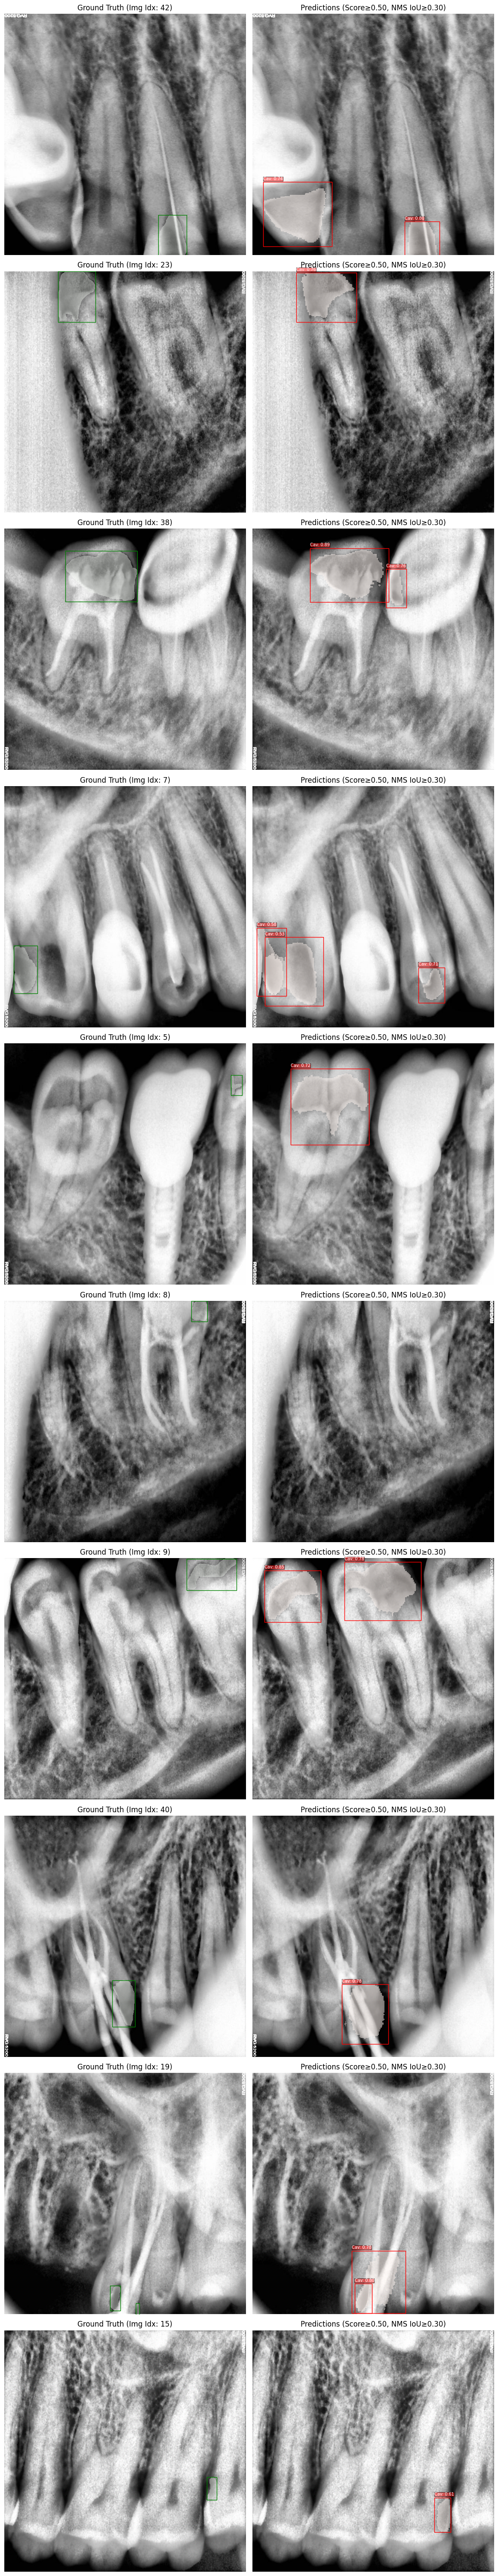

In [16]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np
import torch
import torchvision.ops
import albumentations as A
from albumentations.pytorch import ToTensorV2

image_size_for_transform = 256
def visualize_predictions(model, dataset, device, num_samples=3, score_threshold=0.5, nms_iou_threshold=0.3):
    model.eval()
    
    # Ensuring transforms are removed for raw visualization
    if dataset.transforms is not None:
        print("Creating new otransforms.")
        try:
            dataset = CavityInstanceDataset(valid_df, transforms=None)
        except NameError:
            print("'valid_df' not found.")
            return

    # Randomly sample images for visualization
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    if not indices:
        print("No samples to visualize.")
        return

    # Set up plot
    fig, axes = plt.subplots(len(indices), 2, figsize=(12, len(indices) * 6))
    if len(indices) == 1:
        axes = np.array([axes])

    # Apply basic preprocessing similar to training
    vis_input_transform = A.Compose([
        A.Resize(image_size_for_transform, image_size_for_transform),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    for i, idx in enumerate(indices):
        img_tensor_raw, target = dataset[idx]

        # Load and process original image
        raw_img = cv2.imread(dataset.df.iloc[idx]['image_path'])
        if raw_img is None:
            continue
        raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
        h, w = raw_img.shape[:2]

        # Apply transforms for inference
        transformed = vis_input_transform(image=raw_img)
        model_input_img = transformed['image'].to(device)

        # Forward pass to get predictions
        with torch.no_grad():
            predictions = model([model_input_img])
        prediction = predictions[0]

        # Get predictions above score threshold
        pred_boxes_raw = prediction['boxes'].cpu()
        pred_scores_raw = prediction['scores'].cpu()
        pred_masks_raw = prediction['masks'].cpu()

        keep_scores_idx = pred_scores_raw >= score_threshold
        pred_boxes_thresh = pred_boxes_raw[keep_scores_idx]
        pred_scores_thresh = pred_scores_raw[keep_scores_idx]
        pred_masks_thresh = pred_masks_raw[keep_scores_idx]

        # Apply NMS to suppress overlapping boxes
        final_boxes = np.empty((0, 4))
        final_scores = np.empty(0)
        final_masks = np.empty((0, 1, image_size_for_transform, image_size_for_transform))
        if len(pred_boxes_thresh) > 0:
            keep_nms_idx = torchvision.ops.nms(pred_boxes_thresh, pred_scores_thresh, nms_iou_threshold)
            final_boxes = pred_boxes_thresh[keep_nms_idx].numpy()
            final_scores = pred_scores_thresh[keep_nms_idx].numpy()
            final_masks = pred_masks_thresh[keep_nms_idx].numpy()

        # Load ground truth data
        gt_boxes = target['boxes'].cpu().numpy() if isinstance(target['boxes'], torch.Tensor) else np.array(target['boxes'])
        gt_masks = target['masks'].cpu().numpy() if isinstance(target['masks'], torch.Tensor) else np.array(target['masks'])

        # Plot Ground Truth
        ax_gt = axes[i, 0]
        ax_gt.imshow(raw_img)
        ax_gt.set_title(f'Ground Truth (Img Idx: {idx})')
        ax_gt.axis('off')
        for box in gt_boxes:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=1, edgecolor='g', facecolor='none')
            ax_gt.add_patch(rect)
        if gt_masks.shape[0] > 0:
            combined_gt_mask = np.max(gt_masks, axis=0).astype(bool)
            ax_gt.imshow(np.ma.masked_where(~combined_gt_mask, combined_gt_mask), cmap='Greens', alpha=0.4)

        # Plot Predictions
        ax_pred = axes[i, 1]
        ax_pred.imshow(raw_img)
        ax_pred.set_title(f'Predictions (Score≥{score_threshold:.2f}, NMS IoU≥{nms_iou_threshold:.2f})')
        ax_pred.axis('off')
        for box, score, mask_pred in zip(final_boxes, final_scores, final_masks):
            # Rescale boxes and masks to original size
            scale_x = w / image_size_for_transform
            scale_y = h / image_size_for_transform
            box_scaled = [box[0]*scale_x, box[1]*scale_y, box[2]*scale_x, box[3]*scale_y]
            rect = patches.Rectangle((box_scaled[0], box_scaled[1]),
                                     box_scaled[2] - box_scaled[0], box_scaled[3] - box_scaled[1],
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax_pred.add_patch(rect)
            ax_pred.text(box_scaled[0], box_scaled[1] - 5, f'Cav: {score:.2f}',
                         bbox=dict(facecolor='red', alpha=0.5, pad=0.1),
                         fontsize=7, color='white')
            # Overlay predicted mask
            mask_resized = cv2.resize(mask_pred.squeeze(), (w, h), interpolation=cv2.INTER_NEAREST)
            mask_binary = (mask_resized > 0.5)
            ax_pred.imshow(np.ma.masked_where(~mask_binary, mask_binary), cmap='Reds', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Run visualization
print("Visualizing results from the best model...")

vis_dataset = CavityInstanceDataset(valid_df, transforms=None)
visualize_predictions(model, vis_dataset, train_config.device,
                      num_samples=10,
                      score_threshold=0.5,
                      nms_iou_threshold=0.3)
